# MORDM

Many Objectives Decision Making

MORDM has four main steps:

(i) problem formulation based on a systems analytical problem definition framework

(ii) searching for candidate solutions that optimize multiple objectives by using multi-objective evolutionary algorithms

(iii) generating an ensemble of scenarios to explore the effects of uncertainties

(iv) using scenario discovery to detect the vulnerabilities of candidate solutions and improving thecandidate solutions

In [22]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers,
    Scenario,
    ScalarOutcome
)
import numpy as np
import pandas as pd
import copy
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time, min_over, guaranteed95_over, guaranteed98_over

from ema_workbench.em_framework.optimization import EpsilonProgress

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Select problem formulation 3 - Water Levels
ema_logging.log_to_stderr(ema_logging.INFO)
dike_model, planning_steps = get_model_for_problem_formulation(2)

## Problem Formulation


The room for the river model has 6 outcome indicators. The first four indicators are specific to each dike and the last two concern the model as a whole:
- Expected Annual Damage
- Expected Number of Deaths
- Dike Investment Costs
- Water Level
- RfR Total Costs
- Expected Evacuation Costs

As analysts for the transport company, the capacity to transport goods in the river is heavily dependent on the water level staying above a threshold. Therefore, it is crucial for the problem owner to focus on the policies where this target is met. Nonetheless, based on the insights provided by the different stakeholders during the debate, it becomes imperative to explore options that have the desired water level with the least amount of casualties and costs.

In [3]:
# Model Uncertainties
for uncertainty in dike_model.uncertainties:
    print(repr(uncertainty))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [4]:
# Policy Levers
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [5]:
# Model Outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Minimum Water Level', variable_name=('A.1_Water Level', 'A.2_Water Level', 'A.3_Water Level', 'A.4_Water Level', 'A.5_Water Level'), function=<function min_over_pf2 at 0x0000023F5C93F420>)
ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage', 'A.2_Expected Annual Damage', 'A.3_Expected Annual Damage', 'A.4_Expected Annual Damage', 'A.5_Expected Annual Damage'), function=<function sum_over at 0x0000023F29E358A0>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs', 'A.2_Dike Investment Costs', 'A.3_Dike Investment Costs', 'A.4_Dike Investment Costs', 'A.5_Dike Investment Costs'), function=<function sum_over at 0x0000023F29E358A0>)
ScalarOutcome('RfR Investment Costs', variable_name=('RfR Total Costs',), function=<function sum_over at 0x0000023F29E358A0>)
ScalarOutcome('Evacuation Costs', variable_name=('Expected Evacuation Costs',), function=<function sum_over at 0x0000023F29E358A0>)
ScalarOutcome('Expected Numb

## Candidate Strategies

### Option 1: MORDM
Direct search is used to go through the decision levers to find good candidate strategies that meet the desired outcomes of the problem owner. This method is based on a reference scenario.

In [6]:
# Define a reference scenario. JUST AN EXAMPLE

reference_scenario = Scenario('reference', **{'discount rate 0': 2.5,
                                              'discount rate 1': 2.5,
                                              'discount rate 2': 2.5,
                                              'A.0_ID flood wave shape': 75,
                                              'A.1_Bmax': 190, 'A.1_pfail': (0.2 - 0.0005)/2, 'A.1_Brate': 1.5,
                                              'A.2_Bmax': 190, 'A.2_pfail': 0.5, 'A.2_Brate': 1.5,
                                              'A.3_Bmax': 190, 'A.3_pfail': 0.5, 'A.3_Brate': 1.5,
                                              'A.4_Bmax': 190, 'A.4_pfail': 0.5, 'A.4_Brate': 1.5,
                                              'A.5_Bmax': 190, 'A.5_pfail': 0.5, 'A.5_Brate': 1.5})

In [7]:
# Define metrics for the optimization
convergence_metrics = [EpsilonProgress()]
epsilon = [0.1,] * len(dike_model.outcomes)
nfe = 5  # proof of principle only, way to low for actual use

with MultiprocessingEvaluator(dike_model) as evaluator:
    results, convergence = evaluator.optimize(
        nfe=nfe,
        searchover="levers",
        epsilons=epsilon,
        convergence=convergence_metrics,
        reference=reference_scenario,
        )

[MainProcess/INFO] pool started with 12 workers
100it [00:12,  8.14it/s]                                                       
[MainProcess/INFO] optimization completed, found 19 solutions
[MainProcess/INFO] terminating pool


<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
C:\Users\lilac\AppData\Local\Temp\ipykernel_11680\888765605.py:13: SyntaxWarning: invalid escape sequence '\e'
  ax.set_ylabel('$\epsilon$-progress')


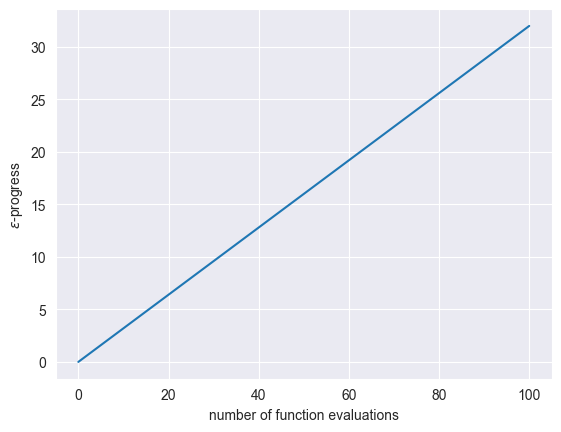

In [8]:
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)
#fig, ax1 = plt.subplots(ncols=1)
#ax1.plot(convergence.epsilon_progress)
#ax1.set_xlabel("nr. of generations")
#ax1.set_ylabel(r"$\epsilon$ progress")
#sns.despine()

import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')

ax.set_xlabel('number of function evaluations')
plt.show()

In [9]:
results
results.to_excel('MORDM.xlsx')
convergence.to_excel('Convergence.xlsx')

In [10]:
# Store results from xlsx to dataframe to not run workbench again -  Too much computational power
results_ = pd.read_excel('MORDM.xlsx')
len(results_)

19

In [19]:
# Store results from xlsx to dataframe to not run workbench again -  Too much computational power
results_ = pd.read_excel('MORDM.xlsx')

# Pareto policies that fulfill defined criteria- Water level above 4
policies = results_[(results_['Minimum Water Level'] > 4.5)]

policies.to_excel('Policies.xlsx')

policies_ = pd.read_excel('Policies.xlsx')
policies_

,Unnamed: 0.1,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,...,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Minimum Water Level,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,9,9,0,1,0,0,0,0,0,1,...,8,8,8,8,4.5387,1.266682e+06,6.535703e+08,627500000,97.647604,0.000078
1,10,10,0,1,0,0,1,0,1,1,...,10,5,3,4,4.5387,2.100554e+06,5.585530e+08,650600000,0.000000,0.003613


In [20]:
len(policies_)

2

All policies fulfill criteria regaring water level threshold.

In [21]:
# Further filter results based on a threshold for total costs
results_filter = results_[results_['RfR Total Costs']< 1000000000]
results_filter.to_excel('Results Filter.xlsx')
policies_ = results_filter
len(policies_)

KeyError: 'RfR Total Costs'

C:\Users\lilac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ema_workbench\analysis\parcoords.py:220: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


<Figure size 3000x500 with 0 Axes>

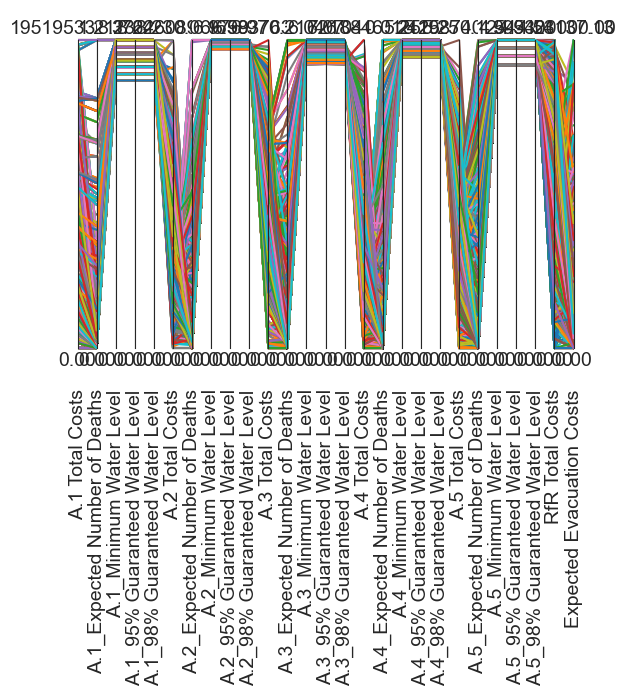

In [26]:
from ema_workbench.analysis import parcoords

data = policies_.loc[:, [o.name for o in dike_model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, [o.name for o in dike_model.outcomes]] = 0

plt.figure(figsize=(30, 5))
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
#paraxes.invert_axis('A.5_Minimum Water Level')
plt.show()

## Candidate Strategies
Re evaluate candidate solutions to assess their robustness. Run EMA workbench again. Reduce the size of the list of the robust policies by adding extra constaints (Insights on the debate)


In [26]:
# Create a list with a format EMA workbench can use
from ema_workbench import Policy

policies_.index = [i for i in range(len(policies_.index))]

# Drop the outcome columns from the policies DataFrame, keeping only the decision variables
policies_pareto = policies_.drop([o.name for o in dike_model.outcomes], axis=1)

policies_to_analyze = []

# Create policy objects
for i, policy in policies_.iterrows():
    policies_to_analyze.append(Policy(str(i), **policy.to_dict()))


In [27]:
# Run experiments again only on selected robust policies
n_scenarios = 1
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_analyze)

experiments, outcomes = results

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 1 scenarios * 2 policies * 1 model(s) = 2 experiments
100%|████████████████████████████████████████████| 2/2 [00:00<00:00,  7.88it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


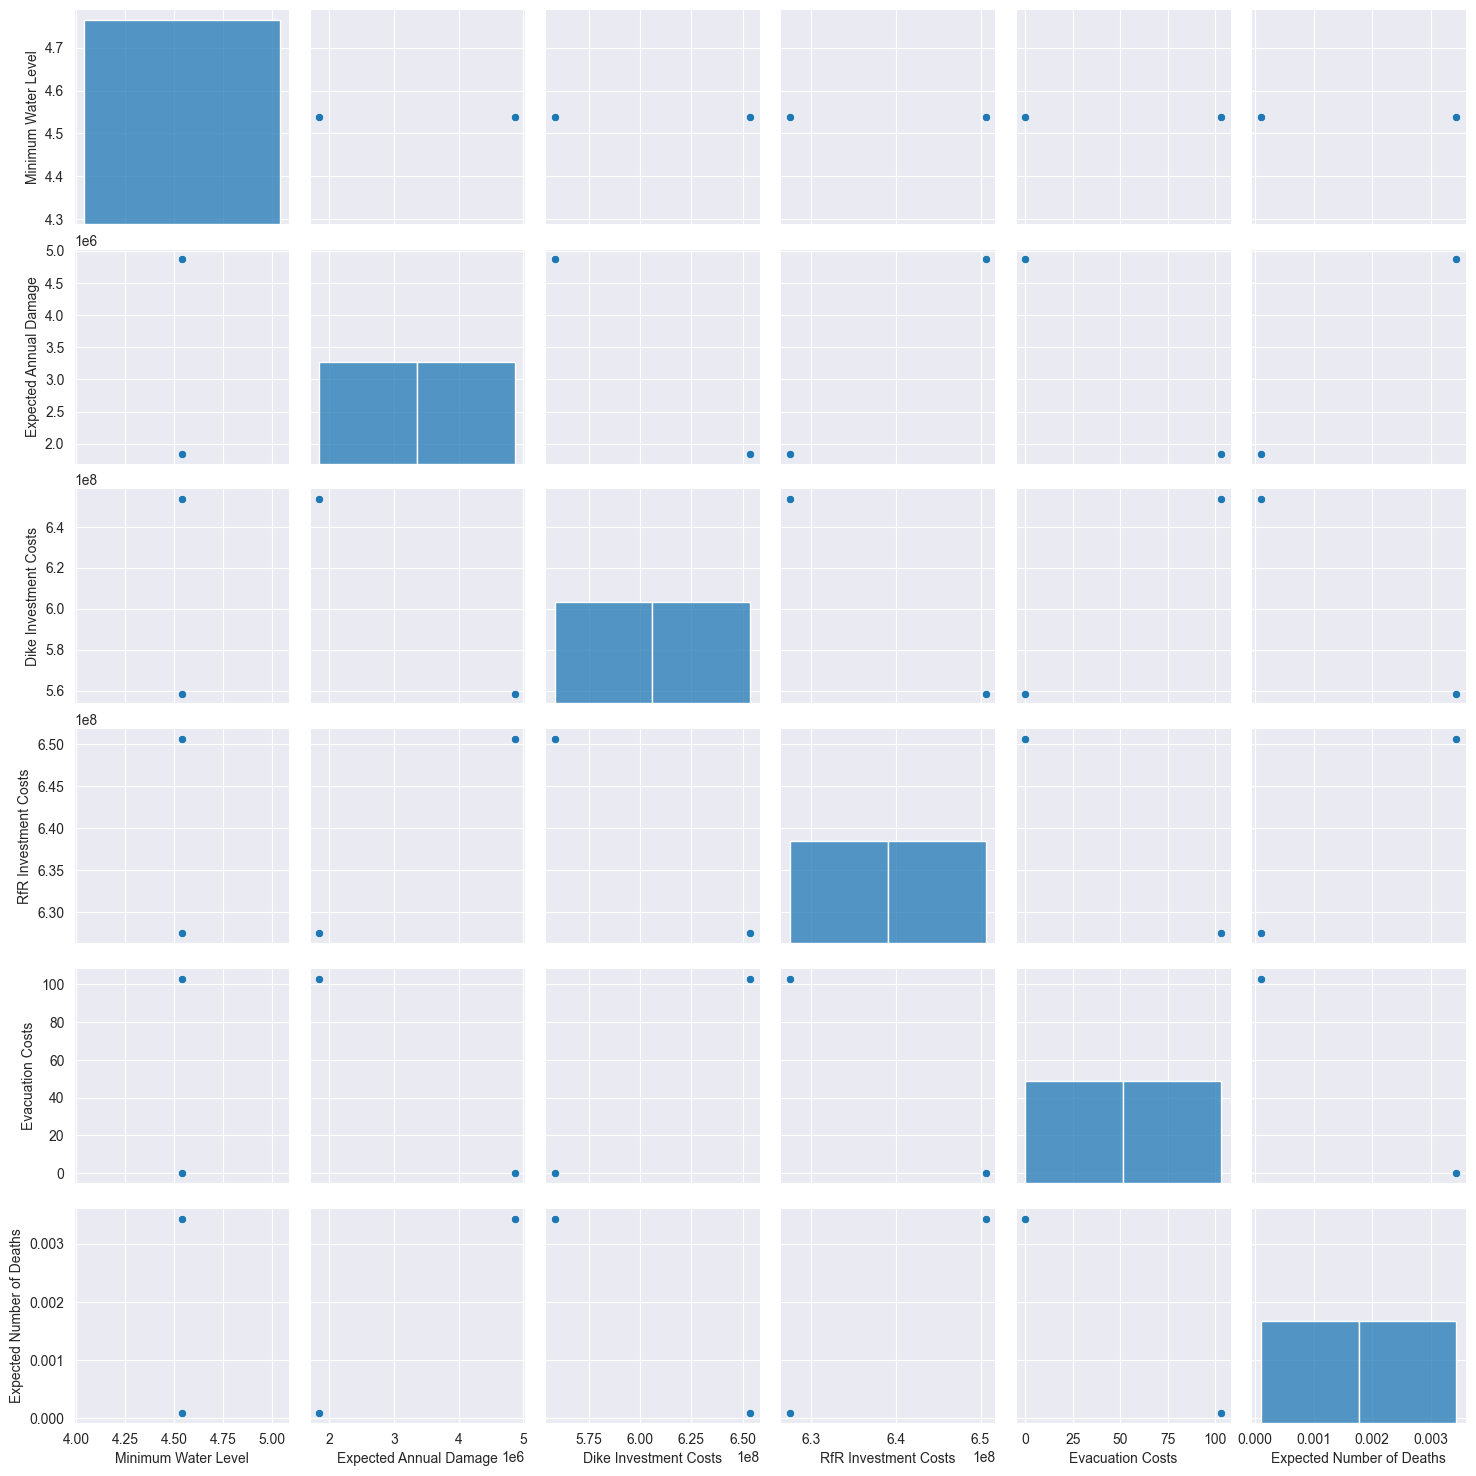

In [28]:
# Plot outcomes
sns.pairplot(pd.DataFrame(outcomes))

<Axes: >

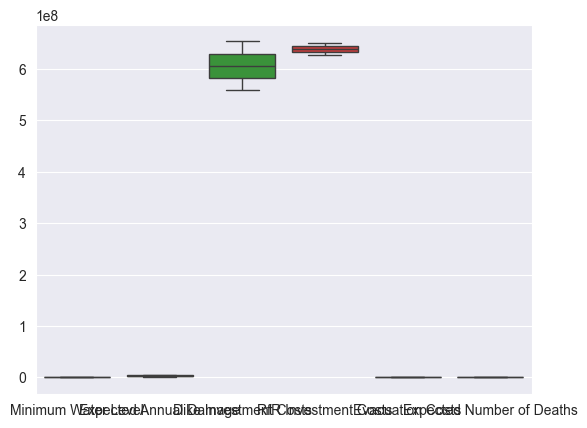

In [29]:
# Outcomes distribution
sns.boxplot(pd.DataFrame(outcomes))

In [ ]:
# Calculate values below the 10th percentile. (Lowest RfR Costs)
#y= outcomes['RfR Total Costs']>np.percentile(outcomes['RfR Total Costs'],10)

### Robustness Analysis

**Signal to Noise**

The signal-to-noise ratio gives an indication of the variation of the outcomes over different scenarios. This metric captures both the average and the standard deviation of the candidate solution. By taking the standard deviation into account not only the average performance, but also the range of the performance of the candidate solutions becomes clear
The aim is to keep this variance as low as possible, as a
narrow range of uncertainty shows robustness (Kwakkel et al., 2016). When the objective needs to be minimised, the signal-to-noise ratio is calculated by multiplying the mean and the standard deviation, as both the mean and the standard deviation needs to be as low as possible. When maximising the objective, the signal-to-noise ratio is calculated by dividing the mean by the standard deviation, as the mean needs to be maximised, while having a minimal standard deviation. Thus, in case of maximisation of the objective, a high signal-to-noise ratio indicates robustness, while in case of minimisation, a low signal-to-noise ratio is preferred.

In [30]:
#Function to calculate the signal to noise ratio
#We want all our signal to noise ratios to be minimized
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [31]:
#Calculate signal to noise scores for every candidate policy
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in dike_model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T

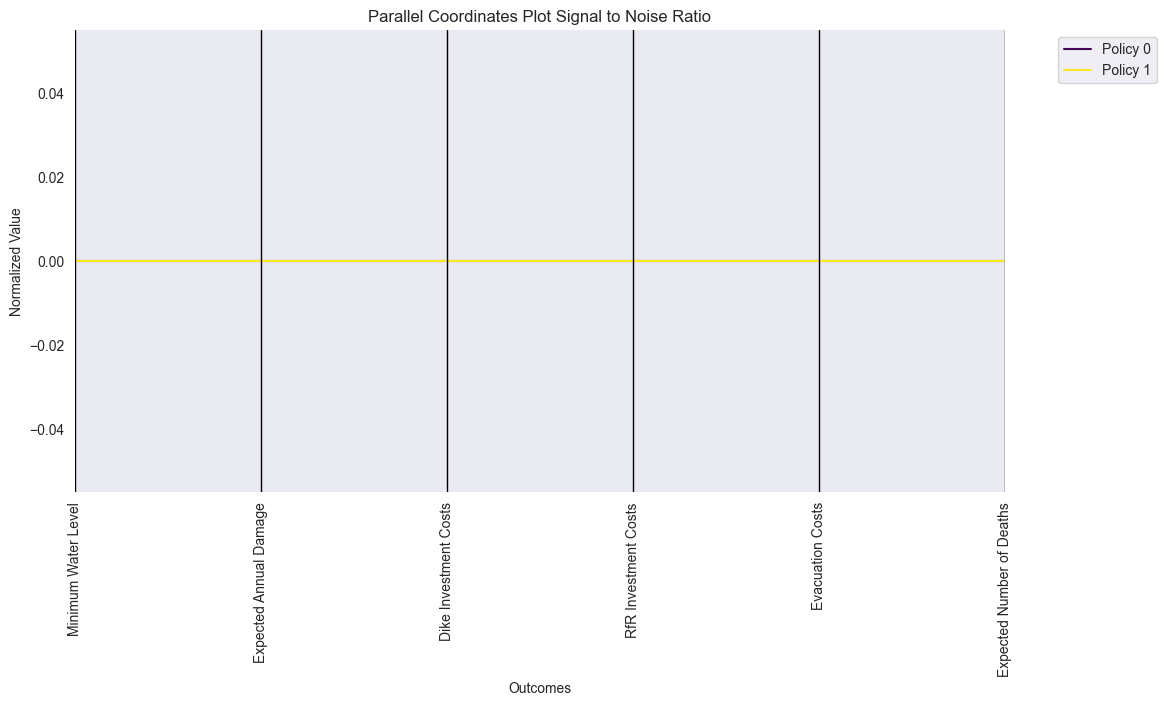

In [33]:
#Plotting with seaborn

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

data1 = scores.copy()

# Normalize the data
zero_columns = data1.columns[(data1 == 0).all()]
data_normalized1 = data1.copy()
for col in data1.columns:
    if col not in zero_columns:
        data_normalized1[col] = (data1[col] - data1[col].min()) / (data1[col].max() - data1[col].min())

data_normalized1['class'] = ['Policy ' + str(i) for i in range(len(data_normalized1))]

plt.figure(figsize=(12, 6))
parallel_coordinates(data_normalized1, 'class', colormap=plt.get_cmap("viridis"))

plt.title("Parallel Coordinates Plot Signal to Noise Ratio")
plt.xlabel("Outcomes")
plt.ylabel("Normalized Value")

ax = plt.gca()

#Makes sure that x labels are vertically positioned
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

#Makes sure the legend is on the right side of the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#Remove the background grid
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.show()

**Maximum Regret**

 Defined for each policy under each scenario, as the difference between the performance of the policy in a specific scenario and the performance of a no-regret (i.e. best possible result in that scenario) policy. The maximum regret is then the maximum of such regret values across all scenarios. We of course favor policy options with low maximum regret values.

In [34]:
#Function to calculate regret
def calculate_regret(data, best):
    return np.abs(best-data)

In [35]:
#Calculate max regret for every policy
overall_regret = {}
max_regret = {}

for outcome in dike_model.outcomes:
    policy_column = experiments['policy']

    # create a DataFrame with all the relevent information
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from
    # pivoting
    data.columns = data.columns.get_level_values(1)

    # we need to control the broadcasting.
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across
    # the row and the actual values in the row
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

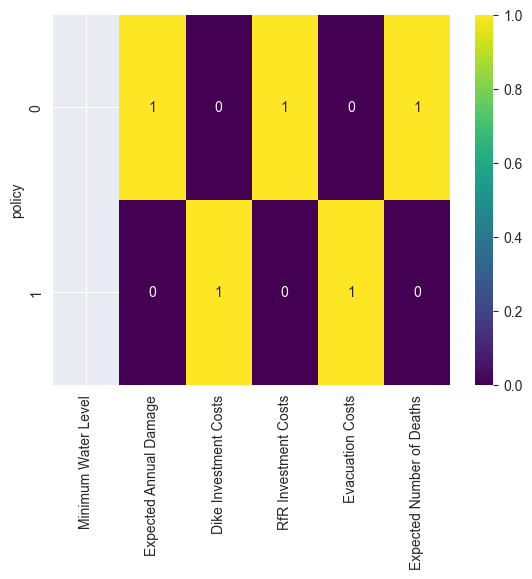

In [36]:
# Create heatmap
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()